In [78]:
# Import packages
import numpy as np
import os
import mahotas as mh
import cv2

In [79]:
from Functions import create_dirs, check_sky, mask_seg, count_animals, smooth_animals, plot_image, get_centers_through_borders, get_bboxes, write_file

In [80]:
bad_image_list = []
Detectron2_bbox_dict = {}

# image height = 60 (2019-10)
# image height = 30 (2019-11)
sigma = 2
minimum_animal_size = 10
kernel = (5,5)
date = "2019-11"
width = 512
height= 512

input_location = "../Data/images/" + date + "/"
input_location_s = "../Data/semantic/" + date + "/"
output_location = "../Data/labels/" + date + "/"


In [81]:
# Create the data directories
create_dirs(date)

Creation of the directory ../Data/images/2019-11 failed
Creation of the directory ../Data/labels/2019-11 failed
Creation of the directory ../Data/images/2019-11 failed


###----------###
IMG139_-35,280.png
###----------###

This image contains 1 animals, including tiny blobs
This image contains 1 animals, excluding tiny blobs
Labeled blobs before erosion


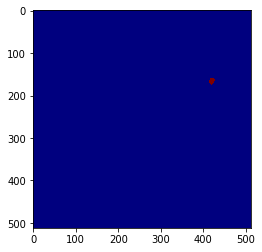

Labeled blobs after dilation


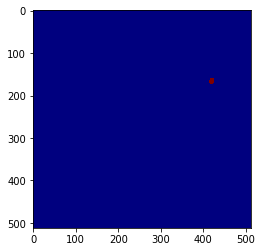

Real image


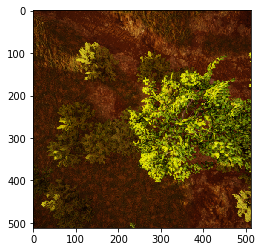

center locations: [(0.8185737423780488, 0.32419493140243905)] 

bboxes: [(0.025390625, 0.02734375)] 

Proper animals found: writing file 

###----------###
IMG13_180,-180.png
###----------###

This image contains 0 animals, including tiny blobs
This image contains 0 animals, excluding tiny blobs
Zero animals in this picture, not adding file information to labels file 

###----------###
IMG140_-20,280.png
###----------###

This image contains 2 animals, including tiny blobs
This image contains 2 animals, excluding tiny blobs
Labeled blobs before erosion


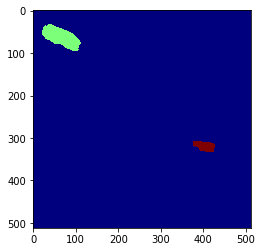

Labeled blobs after dilation


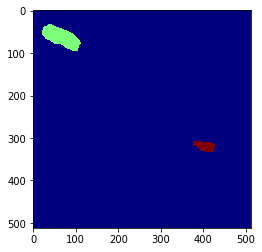

Real image


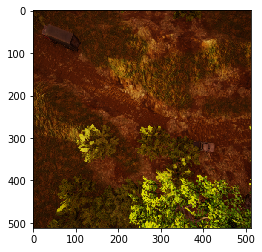

center locations: [(0.1290016351744186, 0.12516805959302327), (0.7844651442307692, 0.6225510817307692)] 

bboxes: [(0.177734375, 0.123046875), (0.099609375, 0.05078125)] 

Proper animals found: writing file 

###----------###
IMG141_-5,280.png
###----------###

This image contains 2 animals, including tiny blobs
This image contains 2 animals, excluding tiny blobs
Labeled blobs before erosion


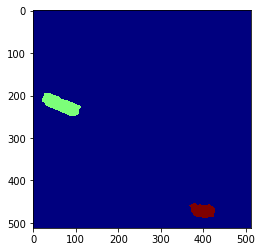

Labeled blobs after dilation


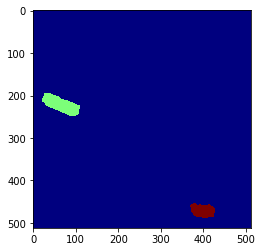

Real image


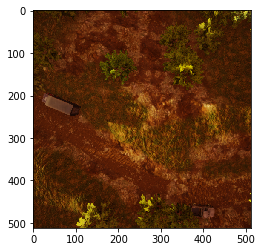

center locations: [(0.12804129464285716, 0.43312872023809523), (0.7760074013157895, 0.9184313322368421)] 

bboxes: [(0.17578125, 0.103515625), (0.115234375, 0.0703125)] 

Proper animals found: writing file 

###----------###
IMG142_10,280.png
###----------###

This image contains 1 animals, including tiny blobs
This image contains 1 animals, excluding tiny blobs
Labeled blobs before erosion


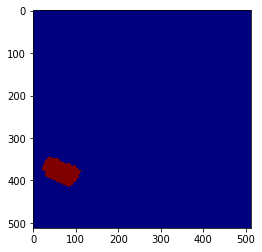

Labeled blobs after dilation


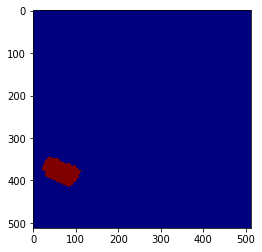

Real image


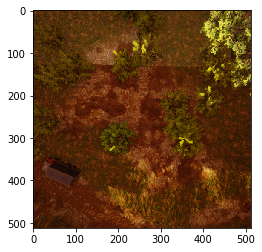

center locations: [(0.12647780696902655, 0.7381429756637168)] 

bboxes: [(0.17578125, 0.13671875)] 

Proper animals found: writing file 

###----------###
IMG143_25,280.png
###----------###

This image contains 1 animals, including tiny blobs
This image contains 1 animals, excluding tiny blobs
Labeled blobs before erosion


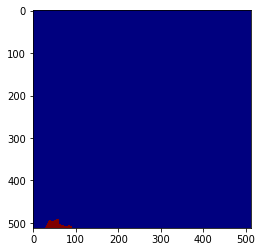

Labeled blobs after dilation


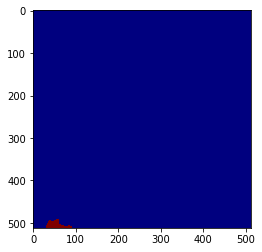

Real image


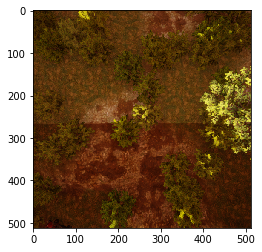

center locations: [(0.11346209490740741, 0.9779128086419753)] 

bboxes: [(0.119140625, 0.0390625)] 

Proper animals found: writing file 

###----------###
IMG144_40,280.png
###----------###

This image contains 0 animals, including tiny blobs
This image contains 0 animals, excluding tiny blobs
Zero animals in this picture, not adding file information to labels file 

###----------###
IMG145_55,280.png
###----------###

This image contains 0 animals, including tiny blobs
This image contains 0 animals, excluding tiny blobs
Zero animals in this picture, not adding file information to labels file 

###----------###
IMG146_70,280.png
###----------###

This image contains 0 animals, including tiny blobs
This image contains 0 animals, excluding tiny blobs
Zero animals in this picture, not adding file information to labels file 

###----------###
IMG147_85,280.png
###----------###

This image contains 0 animals, including tiny blobs
This image contains 0 animals, excluding tiny blobs
Zero anim

In [82]:
with open("../Data/labels/00_SPLIT.txt","w") as file: 
    for image_name in os.listdir("../Data/semantic/" + date)[75:90]: # + "/test"

        if image_name == "/test":
            continue
        # Input image from directory
        print("###----------###" + "\n" + image_name + "\n" + "###----------###" + "\n")
        input_image_s = input_location_s + image_name
        
        
        # If image contains sky, i.e. it's under the ground level, continue, else, write the file to the 00_SPLIT file
        if check_sky(input_image_s) == True:
            print("Warning, image contains sky. Removing from set.")
            bad_image_list.append(image_name)
            continue
        else:
            file.write(date + "/" + image_name + ' ' + "1") # The 1 refers to whether this is for training, test, or dev
            file.write("\n")
        
        
        # Mask everything but animals in image
        animals, mask = mask_seg(input_image_s)

        
        # Smooth animals with gaussian and remove tiny animals less than set size
        animals_smooth = smooth_animals(animals, sigma = sigma)

        
        # Count animals, if no animals are present, skip image
        labeled_animals, nr_objects = count_animals(animals_smooth, minimal_size = minimum_animal_size,image_kernel=kernel)
        if nr_objects == 0:
            print("Zero animals in this picture, not adding file information to labels file", "\n")
            continue
        else:
            plot_image(input_location + image_name)
        
        # Get centers of animals using boundaries
        centers_list = get_centers_through_borders(labeled_animals, nr_objects, width = width, height = height)
        
        
        # Get bboxes of animals in image
        #centers_list = get_centers(animals_smooth,clean_distance = clean_distance) # old
        bbox_list, bbox_dict_list = get_bboxes(labeled_animals, width = width, height = height)

        
        # Output centers and bboxes
        write_file(output_location,image_name,centers_list,bbox_list)
        
        # Make dict of bboxes for Detectron2
        if bbox_dict_list != None:
            Detectron2_bbox_dict[image_name] = bbox_dict_list
        # 242 289 355 789 790

In [83]:
# Deletes images that have innapropriate compositions in them

print(bad_image_list)
for image in bad_image_list:
    try:
        os.remove(input_location + image)
        os.remove(input_location_s + image)
    except:
        print("File already removed")


[]


In [84]:
img_dir = os.listdir("../Data/images/2019-11/")
seg_dir = os.listdir("../Data/semantic/2019-11/")

In [85]:
def get_animal_dicts(img_dir, seg_dir):
    
    dataset_dicts_list = []
    img_list = os.listdir(img_dir)
    seg_list = os.listdir(seg_dir)
    
    for image in img_list[75:90]:
        
        print(image)
        image_dict = {}
#     file_name: the full path to the image file.
        image_dict["file_name"] = img_dir + image
    
#     sem_seg_file_name: the full path to the ground truth semantic segmentation file.
        image_dict["sem_seg_file_name"] = seg_dir + image

#     image: the image as a numpy array.
        image_dict["image"] = cv2.imread(img_dir + image)
    
#     sem_seg: semantic segmentation ground truth in a 2D numpy array. Values in the array represent category labels.
        image_dict["image"] = cv2.imread(seg_dir + image)
    
#     height, width: integer. The shape of image.
        image_dict["height"], image_dict["width"] = cv2.imread(img_dir + image).shape[:2]
    
#     image_id (str): a string to identify this image. Mainly used by certain datasets during evaluation to identify the image, but a dataset may use it for different purposes.
        image_dict["image_id"] = image[:-4]

#     annotations (list[dict]): the per-instance annotations of every instance in this image. Each annotation dict may contain:
        annotations = []

        if Detectron2_bbox_dict.get(image) != None:

            for box_dict in Detectron2_bbox_dict.get(image):
                annotations_dict = {}
                
                #     bbox (list[float]): list of 4 numbers representing the bounding box of the instance.
                annotations_dict["bbox"] = [box_dict.get("x0"), box_dict.get("y0"), box_dict.get("x1"), box_dict.get("y1")] 
                
                #     bbox_mode (int): the format of bbox. It must be a member of structures.BoxMode. Currently supports: BoxMode.XYXY_ABS, BoxMode.XYWH_ABS.
                annotations_dict["bbox_mode"] = "BoxMode.XYXY_ABS"
                
                #     category_id (int): an integer in the range [0, num_categories) representing the category label. The value num_categories is reserved to represent the “background” category, if applicable.
                annotations_dict["category_id"] = 1
                
                annotations.append(annotations_dict)
       
        
    
    
        image_dict["annotations"] = annotations
        dataset_dicts_list.append(image_dict)
        
        #print(image_dict, "\n")
    return dataset_dicts_list

#from detectron2.data import DatasetCatalog
#DatasetCatalog.register("my_dataset", get_dicts)

In [86]:
get_animal_dicts("../Data/images/2019-11/","../Data/semantic/2019-11/")

IMG139_-35,280.png
IMG13_180,-180.png
IMG140_-20,280.png
IMG141_-5,280.png
IMG142_10,280.png
IMG143_25,280.png
IMG144_40,280.png
IMG145_55,280.png
IMG146_70,280.png
IMG147_85,280.png
IMG148_100,280.png
IMG149_115,280.png
IMG14_195,-195.png
IMG150_130,280.png
IMG151_145,280.png


[{'file_name': '../Data/images/2019-11/IMG139_-35,280.png',
  'sem_seg_file_name': '../Data/semantic/2019-11/IMG139_-35,280.png',
  'image': array([[[ 39, 224,  95],
          [ 39, 224,  95],
          [ 39, 224,  95],
          ...,
          [ 39, 224,  95],
          [ 39, 224,  95],
          [ 39, 224,  95]],
  
         [[ 39, 224,  95],
          [ 39, 224,  95],
          [ 39, 224,  95],
          ...,
          [ 39, 224,  95],
          [ 39, 224,  95],
          [ 39, 224,  95]],
  
         [[ 39, 224,  95],
          [ 39, 224,  95],
          [ 39, 224,  95],
          ...,
          [ 39, 224,  95],
          [ 39, 224,  95],
          [ 39, 224,  95]],
  
         ...,
  
         [[ 80, 250, 232],
          [ 80, 250, 232],
          [ 39, 224,  95],
          ...,
          [ 39, 224,  95],
          [ 39, 224,  95],
          [ 39, 224,  95]],
  
         [[ 80, 250, 232],
          [ 39, 224,  95],
          [ 39, 224,  95],
          ...,
          [ 39, 224,  95